# Scratchpad to study the factorization problem

In [40]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
import math
import pickle
import subprocess
import sys
from dataclasses import dataclass
from pathlib import Path
from tqdm import tqdm

sys.path.append(str(Path("..").resolve()))
save_dir = Path(".").resolve() / "results"

import matplotlib.animation as animation
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from matplotlib import rc
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import torch
import torch.nn as nn
import torch.nn.functional as F

from models.mlp import TransformerFeedForward
from models.normalization import RMSNorm
from visualization.graph import build_1L_graph

DEVICE = torch.device("cuda:0")
SEED = 42
RNG = np.random.default_rng(SEED)
np.random.seed(seed=SEED)
torch.manual_seed(seed=SEED)

Data Generation

In [42]:
vocab_size = 2
bsz = 2048
length = 12
sparsity_index = 5

# we create a modular addition problem on some subset of the input only
data = np.random.rand(bsz, length) // (1 / vocab_size)
targets = data[:, :sparsity_index].sum(axis=1) % vocab_size

test_bsz = 128
test_data = np.random.rand(test_bsz, length) // (1 / vocab_size)
test_targets = test_data[:, :sparsity_index].sum(axis=1) % vocab_size

In [43]:
print(f"Total number of unique sequences {vocab_size ** length}")

Total number of unique sequences 4096


Model

In [44]:
class SoftmaxLayer(nn.Module):
    def __init__(self, emb_dim):
        super(SoftmaxLayer, self).__init__()
        self.emb_dim = emb_dim
        self.query = nn.Linear(emb_dim, 1, bias=False)
        self.value = nn.Linear(emb_dim, emb_dim, bias=False)

    def forward(self, x, verbose=False):
        # x: [bsz, seq_len, emb_dim]
        query = self.query.weight
        key = x
        value = self.value(x)

        attn = query @ key.transpose(-1, -2) / math.sqrt(self.emb_dim)
        attn = F.softmax(attn, dim=-1)
        out = (attn @ value).squeeze(1)
        if verbose:
            return out, attn.squeeze(1)
        return out

In [45]:
@dataclass
class MLPConfig:
    activation: float = "gelu"
    emb_dim: bool = None
    ffn_dim: bool = None
    ffn_bias: bool = False
    ffn_dropout: float = 0

    def __post_init__(self):
        if self.ffn_dim is None:
            self.ffn_dim = 4 * self.emb_dim


class Model(nn.Module):
    def __init__(self, emb_dim, vocab_size):
        super(Model, self).__init__()
        self.token_emb = nn.Embedding(vocab_size, emb_dim)
        self.pos_emb = nn.Embedding(length, emb_dim)

        self.softmax = SoftmaxLayer(emb_dim)
        config = MLPConfig(
            emb_dim=emb_dim,
            ffn_dim=4 * emb_dim,
            ffn_bias=True,
            activation="gelu",
        )
        self.mlp = TransformerFeedForward(config)

        self.output = nn.Linear(emb_dim, vocab_size, bias=False)
        self.output.weight = self.token_emb.weight

        self.norm1 = RMSNorm()
        self.norm2 = RMSNorm()

    def forward(self, x, verbose=False):
        out = self.token_emb(x) + self.pos_emb.weight
        out = self.softmax(self.norm1(out), verbose=verbose)
        if verbose:
            out, attn = out
        out = out + self.mlp(self.norm2(out))
        out = self.output(out)
        if verbose:
            return out, attn
        return out

Model Selection

In [46]:
emb_dim = 2
vocab_size = 2
X = torch.from_numpy(data.astype(int))
model = Model(emb_dim=emb_dim, vocab_size=vocab_size)
model.to(device=DEVICE)

Model(
  (token_emb): Embedding(2, 2)
  (pos_emb): Embedding(12, 2)
  (softmax): SoftmaxLayer(
    (query): Linear(in_features=2, out_features=1, bias=False)
    (value): Linear(in_features=2, out_features=2, bias=False)
  )
  (mlp): TransformerFeedForward(
    (fc1): Linear(in_features=2, out_features=8, bias=True)
    (fc2): Linear(in_features=8, out_features=2, bias=True)
  )
  (output): Linear(in_features=2, out_features=2, bias=False)
  (norm1): RMSNorm()
  (norm2): RMSNorm()
)

Training

In [47]:
niter = 10_000

all_losses = {}
all_accs = {}
all_test_accs = {}
all_attns = {}
names = ["Adam"] #['SGD', 'Adam', 'AdamLN', 'SGDLN']

X = torch.from_numpy(data).to(dtype=torch.long, device=DEVICE)
Y = torch.from_numpy(targets).to(dtype=torch.long, device=DEVICE)

X_test = torch.from_numpy(test_data).to(dtype=torch.long, device=DEVICE)
Y_test = torch.from_numpy(test_targets).to(dtype=torch.long, device=DEVICE)

for name in names:
    print(name, flush=True)
    if name[:3] == "SGD":
        lr = 1e-1
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0)
    else:
        # lr = 1e-3 # emb_dim == 8
        # lr = 1e-2 # emb_dim == 4
        lr = 1e-2 # emb_dim == 2
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    losses = torch.zeros(niter)
    accs = torch.zeros(niter)
    test_accs = torch.zeros(niter)
    attns = torch.zeros((niter, test_bsz, length))

    for i in tqdm(range(niter)):
        optimizer.zero_grad()

        # compute loss
        score = model(X, verbose=False)
        loss = F.cross_entropy(score.view((-1, vocab_size)), Y.view(-1))

        loss.backward()
        optimizer.step()

        # record statistics
        with torch.no_grad():
            losses[i] = loss.item()
            accs[i] = (score.argmax(-1) == Y).float().mean()
            score_test, attn = model(X_test, verbose=True)
            test_accs[i] = (score_test.argmax(-1) == Y_test).float().mean()
            attns[i] = attn

    all_losses[name] = losses
    all_accs[name] = accs
    all_test_accs[name] = test_accs
    all_attns[name] = attns

Adam


  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:29<00:00, 335.50it/s]


In [48]:
save_dir = Path(save_dir)
save_dir.mkdir(parents=True, exist_ok=True)

# save model
torch.save(model.state_dict(), save_dir / f"{name}.pt")

with open(save_dir / "losses.pkl", "wb") as f:
    pickle.dump(all_losses, f)
with open(save_dir / "accs.pkl", "wb") as f:
    pickle.dump(all_accs, f)
with open(save_dir / "attns.npy", "wb") as f:
    np.save(f, all_attns["Adam"])

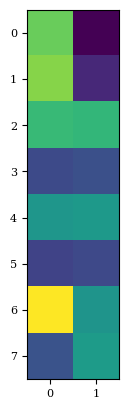

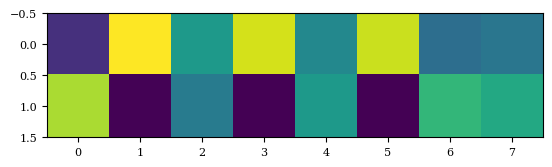

In [49]:
plt.figure()
plt.imshow(model.mlp.fc1.weight.cpu().detach().numpy())
plt.figure()
plt.imshow(model.mlp.fc2.weight.cpu().detach().numpy())

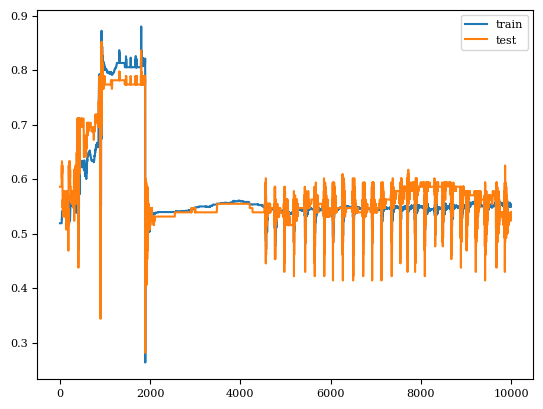

In [50]:
plt.plot(all_accs["Adam"], label="train")
plt.plot(all_test_accs["Adam"], label="test")
plt.legend()

Visualize attention evolution

In [51]:
attns = np.load(save_dir / "attns.npy", allow_pickle=True)
attns.shape

(10000, 128, 12)

MovieWriter imagemagick unavailable; using Pillow instead.


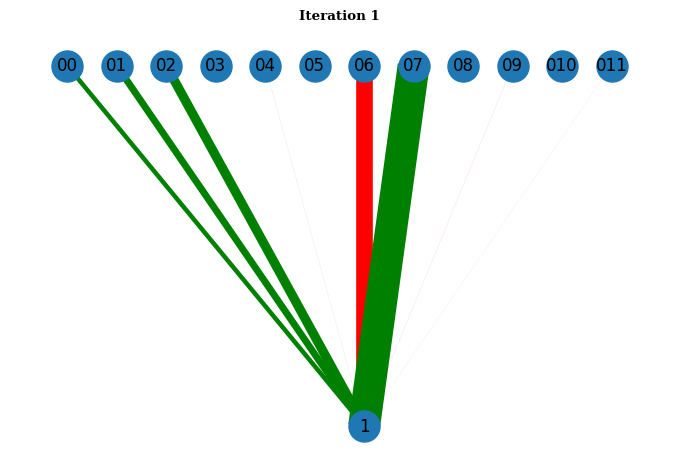

In [52]:
plt.rc("font", family="serif", size=8)

WIDTH = 8.5  # inches (from ICML style file)
HEIGHT = 8.5 / 1.5  # golden ratio
sample = 1

rc("font", family="serif", size=8)
usetex = not subprocess.run(["which", "pdflatex"]).returncode
usetex = False
rc("text", usetex=usetex)
if usetex:
    rc("text.latex", preamble=r"\usepackage{times}")

N = 12

fig, ax = plt.subplots(figsize=(WIDTH, HEIGHT))
G, pos = build_1L_graph(N)
magnifier = 50
weights = 0


def update(frame):
    global weights

    # update variables
    ax.clear()
    old_weights = weights
    # weights = attns[10 * frame].mean(axis=0)
    weights = attns[10 * frame, sample]
    T = 0.01
    weights = np.exp(weights / T)
    weights /= np.sum(weights)

    # color edges according to updates
    diff = weights - old_weights
    colors = ["green" if d > 0 else "red" for d in diff]

    # draw the updated graph
    nx.draw(
        G,
        pos,
        width=magnifier * weights,
        with_labels=True,
        edge_color=colors,
        node_size=500,
        ax=ax,
    )
    ax.set_title(f"Iteration {frame+1}", fontweight="bold")


ani_length = 1_000
ani = animation.FuncAnimation(fig, update, frames=ani_length, repeat=False)
ani.save(save_dir / "test.gif", writer="imagemagick", fps=5)
#ani.save(f"test_{sample}.mp4", writer="ffmpeg", fps=10)

Analysis of MLP layers

In [53]:
X_test[0]

tensor([0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0], device='cuda:0')

In [54]:
X_test[1]

tensor([1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0], device='cuda:0')

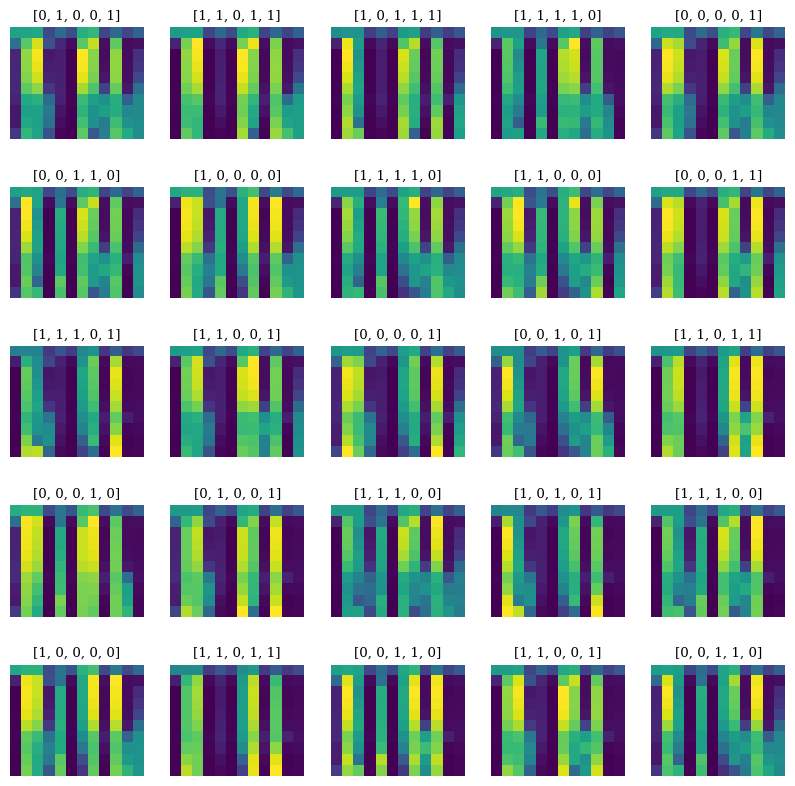

In [55]:
fig, ax = plt.subplots(5, 5, figsize=(10, 10))

for i in range(25):
    ax[i // 5, i % 5].imshow(attns[::1000,i,:])
    ax[i // 5, i % 5].set_title(f"{X_test[i,:5].tolist()}")
    ax[i // 5, i % 5].axis('off')
# plt.colorbar()

In [56]:
torch.set_printoptions(linewidth=200)
torch.from_numpy(attns[-1, 0:5, :])

tensor([[0.0337, 0.1401, 0.1129, 0.0317, 0.0033, 0.0022, 0.1520, 0.0269, 0.0507, 0.1491, 0.1542, 0.1433],
        [0.0029, 0.1569, 0.1264, 0.0024, 0.0037, 0.0026, 0.1702, 0.0302, 0.0045, 0.1670, 0.1726, 0.1605],
        [0.0033, 0.1971, 0.1769, 0.0027, 0.0043, 0.0028, 0.1946, 0.0345, 0.0052, 0.1909, 0.0041, 0.1835],
        [0.0025, 0.1342, 0.1324, 0.0020, 0.1139, 0.0021, 0.1456, 0.1246, 0.0485, 0.1428, 0.1477, 0.0038],
        [0.0331, 0.1515, 0.1111, 0.0312, 0.0033, 0.0021, 0.1496, 0.0265, 0.0499, 0.1490, 0.1517, 0.1410]])

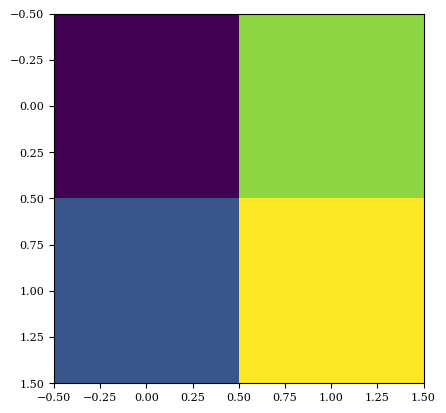

In [57]:
plt.imshow(model.softmax.value.weight.cpu().detach().numpy())

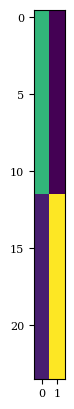

In [58]:
embs = np.vstack([qwe for qwe in model.token_emb.weight.cpu().detach().numpy() for _ in range(12)])
plt.imshow(embs)

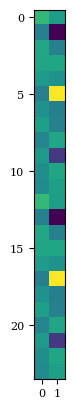

In [59]:
plt.imshow(model.pos_emb.weight.repeat(vocab_size,1).cpu().detach().numpy())

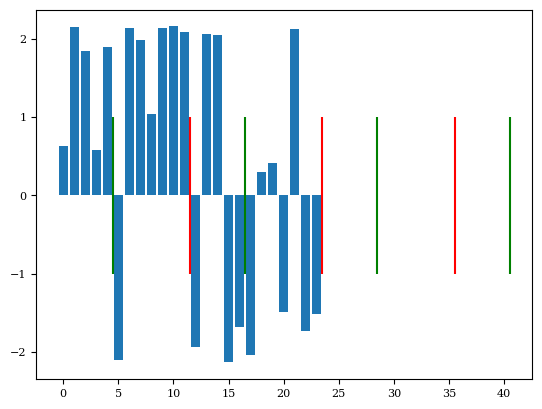

In [60]:
embs = np.vstack([qwe for qwe in model.token_emb.weight.cpu().detach().numpy() for _ in range(12)])
# plt.imshow((zz := model.norm1(torch.from_numpy(embs) + model.pos_emb.weight.repeat(4,1).cpu()).detach().numpy()))
zz = model.norm1(torch.from_numpy(embs) + model.pos_emb.weight.repeat(vocab_size,1).cpu())
attn = model.softmax.query.weight.cpu() @ zz.transpose(-1, -2) / math.sqrt(model.softmax.emb_dim)
plt.bar(range(attn.shape[1]), attn.detach().numpy().flatten())
plt.vlines([11.5, 23.5, 35.5], -1, 1, color='red')
plt.vlines([4.5, 11.5+5, 23.5+5, 35.5+5], -1, 1, color='green')

In [61]:
embs = np.vstack([qwe for qwe in model.token_emb.weight.cpu().detach().numpy() for _ in range(12)])
# plt.imshow((zz := model.norm1(torch.from_numpy(embs) + model.pos_emb.weight.repeat(4,1).cpu()).detach().numpy()))
zz = model.norm1(torch.from_numpy(embs) + model.pos_emb.weight.repeat(vocab_size,1).cpu())
attn = model.softmax.query.weight.cpu() @ zz.transpose(-1, -2) / math.sqrt(model.softmax.emb_dim)
model.softmax.value(zz.cuda()).cpu().shape
out = attn @ model.softmax.value(zz.cuda()).cpu()
out.shape

torch.Size([1, 2])

In [62]:
x = torch.tensor([[(i // 2**4) % 2, (i // 2**3) % 2, (i // 2**2) % 2, (i // 2**1) % 2, i % 2] + [0]*7 for i in range(32)]).cuda()
y = x.sum(dim=1) % 2
z = model.token_emb(x) + model.pos_emb.weight
z = model.norm1(z)
query = model.softmax.query.weight
key = z
value = model.softmax.value(z)
attn = query @ key.transpose(-1, -2) / math.sqrt(model.softmax.emb_dim)
attn = F.softmax(attn, dim=-1)
out = (attn @ value).squeeze(1)
out2 = out + model.mlp(model.norm2(out))
out3 = model.output(out2)

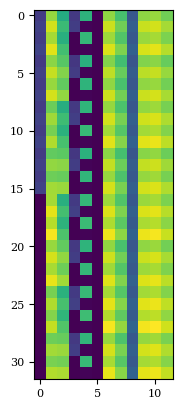

In [63]:
plt.imshow(attn.squeeze().cpu().detach().numpy())

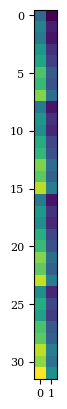

In [64]:
plt.imshow(out.squeeze().cpu().detach().numpy())

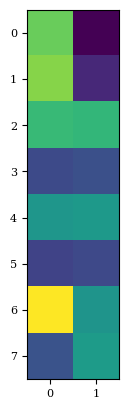

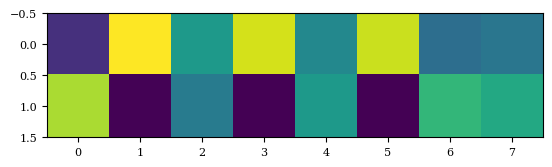

In [65]:
plt.figure()
plt.imshow(model.mlp.fc1.weight.cpu().detach().numpy())
plt.figure()
plt.imshow(model.mlp.fc2.weight.cpu().detach().numpy())

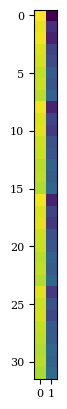

In [66]:
plt.imshow(model.norm2(out).squeeze().cpu().detach().numpy())

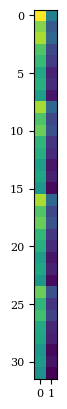

In [67]:
plt.imshow(model.mlp(model.norm2(out)).squeeze().cpu().detach().numpy())

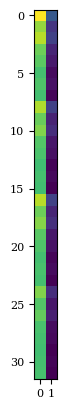

In [68]:
plt.imshow(out2.squeeze().cpu().detach().numpy())

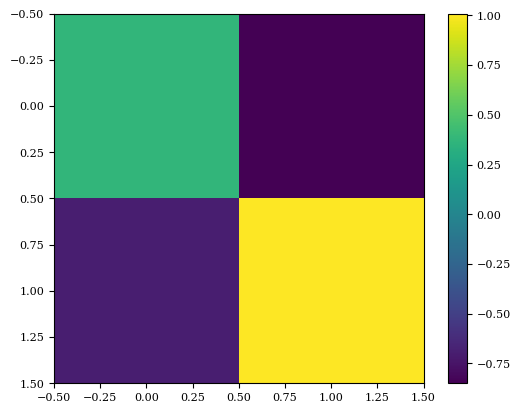

In [69]:
plt.imshow(model.output.weight.cpu().detach().numpy())
plt.colorbar()

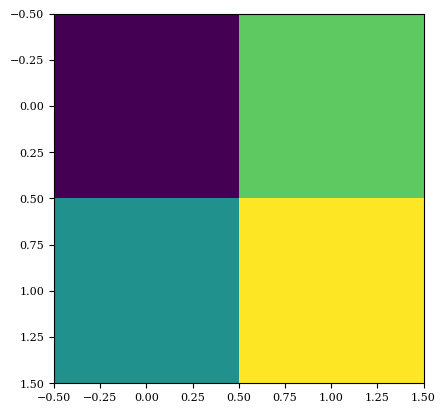

In [70]:
plt.imshow(model.output.weight.cpu().detach().abs().numpy())

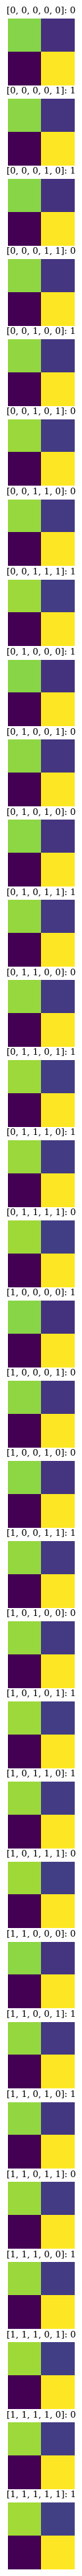

In [71]:
fig, ax = plt.subplots(32, 1, figsize=(7, 50))
for i in range(32):
    ax[i].imshow((model.output.weight * out2[i:i+1,:]).cpu().detach().numpy())
    ax[i].set_title(f"{x[i, :5].tolist()}: {y[i].item()}")
    ax[i].axis('off')

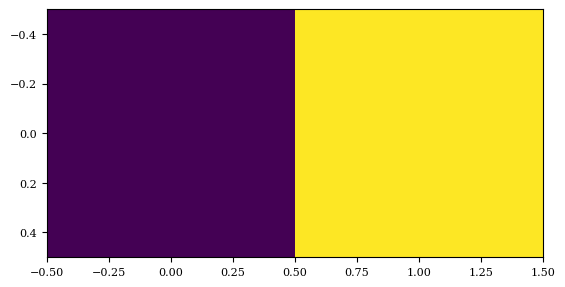

In [72]:
plt.imshow((model.output.weight * out2[:1,:]).sum(dim=-1).unsqueeze(0).cpu().detach().numpy())

In [73]:
(model.output.weight * out2[:1,:]).sum(dim=-1).unsqueeze(0).cpu().detach().numpy()

array([[-0.56557643, -0.33446813]], dtype=float32)

In [74]:
torch.set_printoptions(linewidth=400)
model.output.weight[:2,:]

tensor([[ 0.3725, -0.8504],
        [-0.6941,  1.0089]], device='cuda:0', grad_fn=<SliceBackward0>)

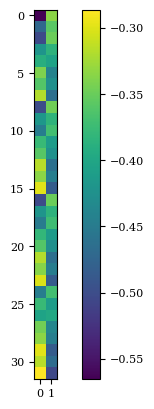

In [75]:
plt.imshow(out3.squeeze().cpu().detach().numpy())
plt.colorbar()

## t-SNE visualization

### TO DO
- Define representatives of equivalence class for the group of permutations
- Associate to each input sequence a label that correspond to the representative (from 1 to 5)

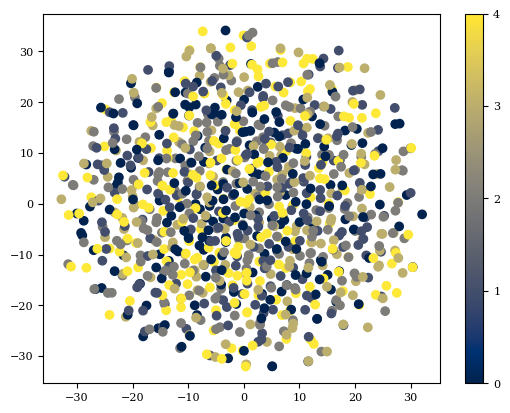

In [76]:
# Define a toy input of N input vectors of dimension 32
# this represents the output after attention or 1st MLP layer for instance
emb_dim = 32
N = 1000
input = np.random.rand(N, 32)  # input vector
target = np.random.randint(low=0, high=5, size=N)  # associated representative elements

# TSNE embeddings
emb = TSNE().fit_transform(input)

cmap = "cividis"
marker = "o"
plt.scatter(emb[:, 0], emb[:, 1], c=target, marker=marker, cmap=cmap)
plt.colorbar(ticks=np.arange(5))
plt.show()

## PCA visualization

### TO DO
Same as above: define representative and associate each point to it, then plot PCA on same figure for with the associated colors

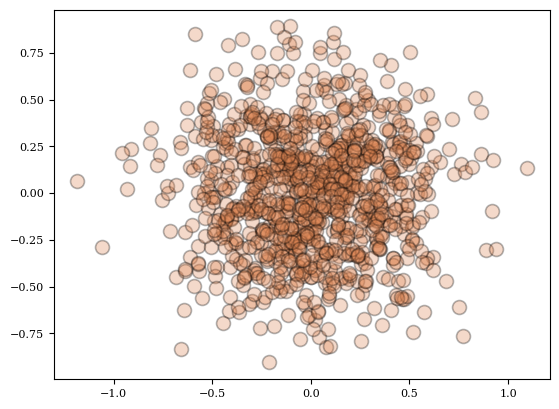

In [77]:
# Define a toy input of N input vectors of dimension 32
# this represents the output after attention or 1st MLP layer for instance
emb_dim = 32
N = 1000
input = np.random.rand(N, 32)  # input vector
target = np.random.randint(low=0, high=5, size=N)  # associated representative elements

# PCA embeddings
emb = PCA().fit_transform(input)


myplot = lambda x, y, color, alpha, marker, ax, label: ax.scatter(
    x=x,
    y=y,
    s=100,
    edgecolors="k",
    color=color,
    alpha=alpha,
    marker=marker,
    linewidths=1.2,
    label=label,
)

# PCA
_, ax = plt.subplots()
myplot(
    x=emb[:, 0],
    y=emb[:, 1],
    color="#dd8452",
    alpha=0.3,
    marker="o",
    ax=ax,
    label="",
)
plt.show()